# Introduction to Python for Data Science: Final Project
by Merveille Maroya-Powell



# Introduction
Throughout history, education has played a vital role in lifting people and giving them a fighting chance. In the US mainly, education has been a tool used to accomplish great things, one of which is the use of education to inform the horrors of racial inequalities. Rulings like Brown versus Board of Education of Topeka gave African Americans an excellent opportunity for integrated education. The 1950s and 1960s were instrumental decades for the Civil Rights movement. Activists from all walks of life came together to fight for their rights. Among these brave folks are women, who didn’t only have to fight racial injustice but gender inequalities too. Education-driven actions, such as Dorothy Counts attending an all white High School in 1957 or Ruby Bridges attending newly integrated elementary school in 1960, paved the way for others to follow suit.

This research examines the intersection between education, race, gender, and activism. When discussing the Civil Rights movement, big names, such as Dr. Martin Luther King Jr., and women like Rosa Parks, Ella Baker, Fannie Lou Hamer, Angela Davis, and many more, come to mind. One wonders how education shaped their minds into action and how many of them got a college degree. Due to education disparities for African Americans and the struggle for women to get equal higher education, one would think African American women most likely didn’t have great opportunities for getting college educations. Thus, one wonders if that hindered their contribution and recognition for advocacy and activism.


# Research Question

The research question this project is set out to explore is: What differences exist in African American activists' recognition and visibility, and how do formal and informal educations affect their importance and impact in advocacy, especially for women in American history?


  Education is a factor that fuels the platform for activism and advocacy. A deeper dive into the school ranking or the field of study matters based on the list of African American activism in the 1950s and 1960s provides insight for current aspiring activists. One can hypothesize that there's a correlation between the school's ranking, which can affect the quality of the education and the field of study. With an increased pushback on traditional gender roles, there was an increase in women obtaining higher education. According to an article by Goldin et al., 2006, there was a significant increase in college enrollment and graduation rates among women in the 1940s well into the 1960s. However, one can expect these enrollment numbers to be lower among African American women due to racial discrimination and segregation during this period. Hence, this research into African American women's education in relation to their activism is so important. It will paint a picture of the challenges they had to overcome to fight for their rights.


# Data Collection
The dataset used for this analysis is the Wikipedia list of List of African American activists. The list can be accessed [here](https://en.wikipedia.org/wiki/List_of_African-American_activists); please note this list may change after the analysis for this research is completed. The following steps will be taken during the data collection and wrangling phase. First, that data will be scrapped and uploaded carefully to ensure only relevant information is obtained. The initial data will be saved as a JSON and uploaded for further analysis.

The saved and uploaded data will be filtered down to include the following – gender, college degree or not.

In [1]:
#Importing the necessary packages to use the API to obtain the Wikipedia list
import requests
from bs4 import BeautifulSoup
import time
import json
import os
import urllib.request as url
import matplotlib.pyplot as plt
import re
import pandas as pd
import numpy as np
import seaborn as sns
import string
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm


In [2]:
#Finding the scrapped list
url = 'https://raw.githubusercontent.com/MerveilleMP/AnalyticsProjects/refs/heads/main/AAactivists.json'
AAactivists = pd.read_json(url)


In [3]:
#Checking the data to ensure it was correctly uploaded
print(AAactivists.head())

                                                   0
0  Ralph Abernathy, civil rights activist and min...
1  Muhammad Ali, civil rights activist https://en...
2  Naomi Anderson, civil and women's rights activ...
3  Maya Angelou, civil rights activist, writer, p...
4  Ella Baker, civil rights activist https://en.w...


In [4]:
#Check the count to be sure to ensure everything uploaded
len(AAactivists)

213

In [5]:
#Checking the format
print(AAactivists.columns)

RangeIndex(start=0, stop=1, step=1)


In [6]:
#Reformat the data structure
AAactivists1 = pd.DataFrame(AAactivists[0], columns=[0])


In [7]:
#Function to separate names and URLs
def extract_name_and_url(text):
    #Using regex to find URL at the end
    match = re.search(r"(.*?)(https?://\S+)?$", text.strip())
    name = match.group(1).strip()
    url = match.group(2).strip() if match.group(2) else None
    return name, url

In [8]:
#Applying the function to the DataFrame and creating new columns for name and URL
AAactivists1[['name', 'url']] = AAactivists1[0].apply(lambda x: pd.Series(extract_name_and_url(x)))

In [9]:
# Check the result
print(AAactivists1.head())

                                                   0  \
0  Ralph Abernathy, civil rights activist and min...   
1  Muhammad Ali, civil rights activist https://en...   
2  Naomi Anderson, civil and women's rights activ...   
3  Maya Angelou, civil rights activist, writer, p...   
4  Ella Baker, civil rights activist https://en.w...   

                                                name  \
0  Ralph Abernathy, civil rights activist and min...   
1                Muhammad Ali, civil rights activist   
2  Naomi Anderson, civil and women's rights activ...   
3  Maya Angelou, civil rights activist, writer, poet   
4                  Ella Baker, civil rights activist   

                                             url  
0  https://en.wikipedia.org/wiki/Ralph_Abernathy  
1     https://en.wikipedia.org/wiki/Muhammad_Ali  
2   https://en.wikipedia.org/wiki/Naomi_Anderson  
3     https://en.wikipedia.org/wiki/Maya_Angelou  
4       https://en.wikipedia.org/wiki/Ella_Baker  


***The newly uploaded data to reflects the list of African American Activists. Next, the scrapping of each of their pages.***

In [10]:
#Scrapping Wikipedia page and return all content
def fullpage(url, activist_name):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    #Extract the activist name
    title = soup.find('h1', {'id': 'firstHeading'}).text.strip()

  #Starting with an empty list
    content = []

    #Extracting all text content even images, languages
    for element in soup.find_all(['p', 'h2', 'h3', 'ul', 'ol', 'span' 'table', 'img']):
        if element.name == 'img':
            img_url = element.get('src', '')
            if img_url:
                content.append({'image_url': 'https:' + img_url if not img_url.startswith('http') else img_url})
        else:
            content.append({'tag': element.name, 'text': element.get_text(strip=True)})

    #Returning a dictionary of the scraped data
    return {
        'name': activist_name,
        'title': title,
        'content': content
    }

In [11]:
#Function to keep all the data
def Foractivists_data(activists_df):
  #Starting with an empty list
    all_data = []

    for _, row in activists_df.iterrows():
        name = row['name']
        url = row['url']

        if not url:
            print(f"Warning: Missing or invalid URL for {name}. Skipping...")
            continue

        data = fullpage (url, name)

        #Add the data to the results list
        all_data.append(data)

    return all_data

In [12]:
#Going through and scrapping each page
scraped_data = Foractivists_data(AAactivists1)


In [13]:
#Save the scraped data to a JSON file
with open('AllDetailsAAA.json', 'w') as f:
    json.dump(scraped_data, f, indent=4)

In [14]:
#Print some of the results to verify
print(json.dumps(scraped_data, indent=4)[:2000])

[
    {
        "name": "Ralph Abernathy, civil rights activist and minister[3]",
        "title": "Ralph Abernathy",
        "content": [
            {
                "tag": "ul",
                "text": "Main pageContentsCurrent eventsRandom articleAbout WikipediaContact us"
            },
            {
                "tag": "ul",
                "text": "HelpLearn to editCommunity portalRecent changesUpload file"
            },
            {
                "image_url": "https:/static/images/icons/wikipedia.png"
            },
            {
                "image_url": "https:/static/images/mobile/copyright/wikipedia-wordmark-en.svg"
            },
            {
                "image_url": "https:/static/images/mobile/copyright/wikipedia-tagline-en.svg"
            },
            {
                "tag": "ul",
                "text": ""
            },
            {
                "tag": "ul",
                "text": ""
            },
            {
                "tag": "ul",
  

***Now that the necessary data has been scrapped from
each activists' page and uploaded, the next section will delve into the analysis of the collected data. The objective of the data analysis section is to answer the research question posed earlier.***

In [15]:
#Upload the saved data from each activists' page
from google.colab import files

with open('AllDetailsAAA.json', 'r') as json_file:
    AllDetailsAAA = json.load(json_file)

In [16]:
#See a preview of the new data
print(json.dumps(AllDetailsAAA, indent=4)[:3000])

[
    {
        "name": "Ralph Abernathy, civil rights activist and minister[3]",
        "title": "Ralph Abernathy",
        "content": [
            {
                "tag": "ul",
                "text": "Main pageContentsCurrent eventsRandom articleAbout WikipediaContact us"
            },
            {
                "tag": "ul",
                "text": "HelpLearn to editCommunity portalRecent changesUpload file"
            },
            {
                "image_url": "https:/static/images/icons/wikipedia.png"
            },
            {
                "image_url": "https:/static/images/mobile/copyright/wikipedia-wordmark-en.svg"
            },
            {
                "image_url": "https:/static/images/mobile/copyright/wikipedia-tagline-en.svg"
            },
            {
                "tag": "ul",
                "text": ""
            },
            {
                "tag": "ul",
                "text": ""
            },
            {
                "tag": "ul",
  

In [17]:
#download data just to view
#files.download('AllDetailsAAA.json')

# Data Analysis
The following analysis will be made to determine if the level of education obtained by the activist, has an impact on their contribution and how these correlates among women versus men in the activisit movements.

*   How many words on the page?
*   How many images on the page?
*   How many section titles?
*   How many activists are educated versus not?







### Counting the number of words on each page

In [18]:
#Create a function to process the count
def count_words_in_page(page_data):

  #initialize with an empty list
    total_word_count = 0

    # Loop through each 'content' entry in the page
    for content_item in page_data['content']:
        # Check if the 'text' key exists and is not empty
        if 'text' in content_item and content_item['text'].strip():
            # Get the text content
            text = content_item['text']
            #Removing extra spaces
            words = re.findall(r'\w+', text)
            #Add the word count to the total
            total_word_count += len(words)

    return total_word_count


In [19]:
#Counting how many words per page
for page in AllDetailsAAA:
  word_count = count_words_in_page(page)
  page['word_count'] = word_count
  print(f"{page['title']}, *with a word count of*:{word_count}")


Ralph Abernathy, *with a word count of*:7804
Muhammad Ali, *with a word count of*:27754
Naomi Anderson, *with a word count of*:1308
Maya Angelou, *with a word count of*:13458
Ella Baker, *with a word count of*:7237
James Baldwin, *with a word count of*:20149
Marion Barry, *with a word count of*:11980
Daisy Bates (activist), *with a word count of*:6460
Carl Bean, *with a word count of*:645
Arekia Bennett, *with a word count of*:851
Mary McLeod Bethune, *with a word count of*:9244
James Bevel, *with a word count of*:7379
Sojourner Truth, *with a word count of*:11608
Gloria Blackwell, *with a word count of*:3240
Unita Blackwell, *with a word count of*:5445
Julian Bond, *with a word count of*:6319
Lillie Mae Bradford, *with a word count of*:872
Ruby Bridges, *with a word count of*:4152
Aurelia Browder, *with a word count of*:2569
Ralph Bunche, *with a word count of*:6472
Nannie Helen Burroughs, *with a word count of*:2398
Melanie L. Campbell, *with a word count of*:1000
Beatrice Morrow Can

In [20]:
#count the length
len(AllDetailsAAA)

213

In [21]:
#Finding the mean, median, min, max based on word count
#adding all the word counts
total_word_counts = [page['word_count'] for page in AllDetailsAAA]


In [22]:
#Verify the total word count
total_word_counts


[7804,
 27754,
 1308,
 13458,
 7237,
 20149,
 11980,
 6460,
 645,
 851,
 9244,
 7379,
 11608,
 3240,
 5445,
 6319,
 872,
 4152,
 2569,
 6472,
 2398,
 1000,
 1200,
 1730,
 2111,
 1659,
 395,
 1365,
 1175,
 4253,
 987,
 12332,
 2792,
 6408,
 5076,
 3404,
 2105,
 8298,
 571,
 1972,
 2678,
 3764,
 6156,
 5225,
 2816,
 6169,
 4343,
 12616,
 5275,
 2674,
 7761,
 2567,
 1429,
 24945,
 24345,
 2776,
 595,
 1692,
 13145,
 596,
 5411,
 6467,
 3787,
 595,
 5141,
 4617,
 859,
 6379,
 15575,
 1508,
 2850,
 1628,
 2179,
 5011,
 1286,
 4016,
 13420,
 7534,
 1802,
 2447,
 1274,
 1761,
 9506,
 9401,
 7311,
 6893,
 1391,
 2255,
 3228,
 5251,
 3443,
 6787,
 1066,
 4192,
 9836,
 1580,
 8849,
 1025,
 3198,
 23737,
 3439,
 13530,
 7836,
 1686,
 3930,
 4796,
 2343,
 2922,
 12835,
 7662,
 4033,
 11991,
 678,
 936,
 2994,
 3251,
 10924,
 18172,
 3036,
 6312,
 34439,
 2702,
 2379,
 10243,
 5535,
 3640,
 484,
 5195,
 19303,
 13635,
 3729,
 2577,
 2180,
 10936,
 8264,
 2893,
 3247,
 3839,
 3128,
 5437,
 1523,
 41

In [23]:
#calculating through basic descriptive statistics
mean_word_count = np.mean(total_word_counts)
median_word_count = np.median(total_word_counts)
min_word_count = np.min(total_word_counts)
max_word_count = np.max(total_word_counts)

In [24]:
#print the output for display
print(f"Mean Word Count: {mean_word_count}")
print(f"Median Word Count: {median_word_count}")
print(f"Minimum Word Count: {min_word_count}")
print(f"Maximum Word Count: {max_word_count}")

Mean Word Count: 5879.619718309859
Median Word Count: 3787.0
Minimum Word Count: 395
Maximum Word Count: 34439


In [25]:
#Find would has the miniumn word count
min_word_count_page = min(AllDetailsAAA, key=lambda x: x.get('word_count', 0))
#print their name
print(f"The activist with the lowest word count is {min_word_count_page['title']}, who has {min_word_count_page['word_count']} words on her Wikipedia page.")

The activist with the lowest word count is Jeannette Carter, who has 395 words on her Wikipedia page.


***Creating a visualization of the activists with the most and least word counts on their page.***

In [26]:
#Convert the wordcount into a different format for data viz
AAADataviz1 = []

In [27]:
#Formating to a dictionary
for page in AllDetailsAAA:
  AAADataviz1.append({'Name': page['title'], 'WordCount': page.get('word_count', 0)})

In [28]:
#Creating a dataframe
df = pd.DataFrame(AAADataviz1)

In [29]:
#Arrange the order of the data to make viz better
df = df.sort_values(by='WordCount', ascending=False)

<ipython-input-30-29896828715d>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='WordCount', y='Name', data=df_top_n, palette='viridis')


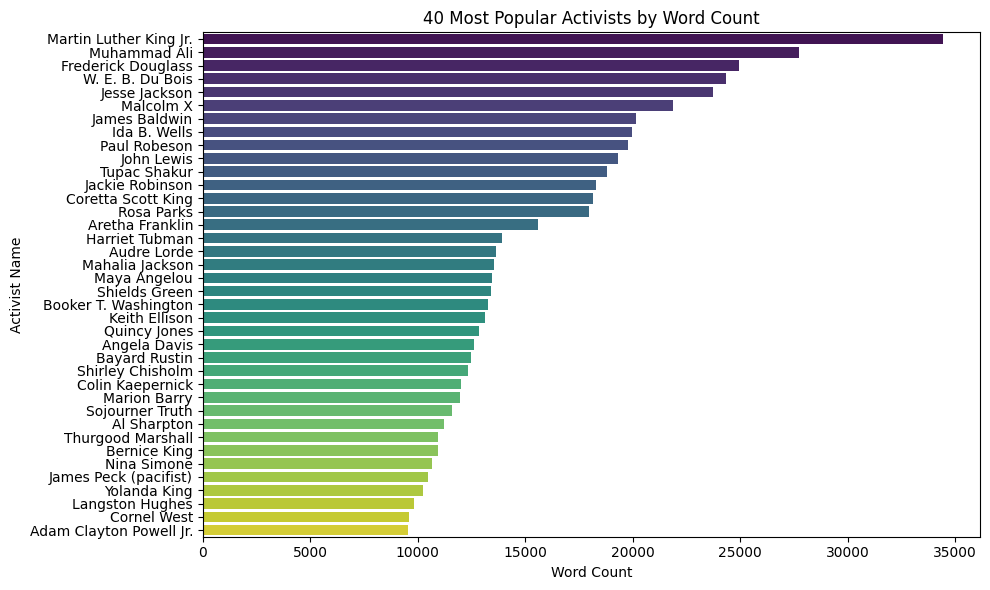

In [30]:
# Getting the top activists with the highest word count
df_top_n = df.nlargest(40, 'WordCount')

# Creating a bar plot for top activists
plt.figure(figsize=(10, 6))
sns.barplot(x='WordCount', y='Name', data=df_top_n, palette='viridis')

#Adding labels  for readability
plt.xlabel('Word Count')
plt.ylabel('Activist Name')
plt.title('40 Most Popular Activists by Word Count')

plt.tight_layout()

<ipython-input-31-b1f7957e7f9c>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='WordCount', y='Name', data=df_lowest_40, palette='viridis')


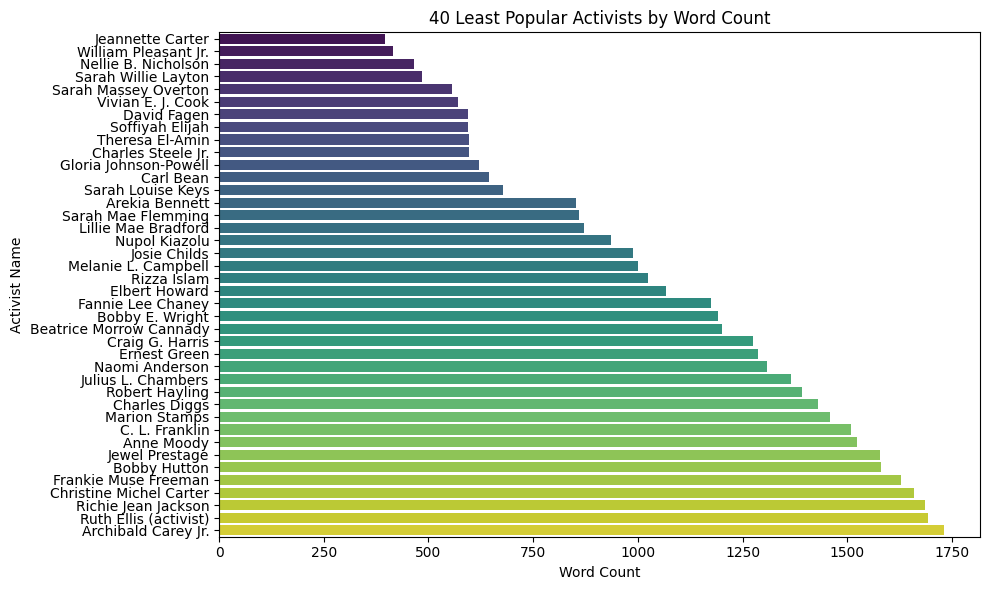

In [31]:
#Create a horizontal bar plot for the least popular activists
df_lowest_40 = df.nsmallest(40, 'WordCount')
plt.figure(figsize=(10, 6))
sns.barplot(x='WordCount', y='Name', data=df_lowest_40, palette='viridis')

#Adding labels for readability
plt.xlabel('Word Count')
plt.ylabel('Activist Name')
plt.title('40 Least Popular Activists by Word Count')

plt.tight_layout()

### Finding Activists Based on their Gender

In [32]:
#Print to double check a few of the data
print(AllDetailsAAA[:3])


[{'name': 'Ralph Abernathy, civil rights activist and minister[3]', 'title': 'Ralph Abernathy', 'content': [{'tag': 'ul', 'text': 'Main pageContentsCurrent eventsRandom articleAbout WikipediaContact us'}, {'tag': 'ul', 'text': 'HelpLearn to editCommunity portalRecent changesUpload file'}, {'image_url': 'https:/static/images/icons/wikipedia.png'}, {'image_url': 'https:/static/images/mobile/copyright/wikipedia-wordmark-en.svg'}, {'image_url': 'https:/static/images/mobile/copyright/wikipedia-tagline-en.svg'}, {'tag': 'ul', 'text': ''}, {'tag': 'ul', 'text': ''}, {'tag': 'ul', 'text': ''}, {'tag': 'ul', 'text': 'DonateCreate accountLog in'}, {'tag': 'ul', 'text': 'DonateCreate accountLog in'}, {'tag': 'ul', 'text': 'ContributionsTalk'}, {'tag': 'h2', 'text': 'Contents'}, {'tag': 'ul', 'text': "(Top)1Early life, family, and education2Civil rights activismToggle Civil rights activism subsection2.1Montgomery bus boycott2.2Southern Christian Leadership Conference and support of Freedom Riders2

In [33]:
#Function to count gender-specific pronouns for activist
def count_genders(content, gender):
    count = 0
    content = content.lower()  # Convert content to lowercase for case-insensitive matching
    content = content.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation

    #Checking each word in the content and count occurrences of pronouns
    for word in content.split():
        if word in gender:
            count += 1
    return count

In [34]:
#Finding male versus female activists
male_gender = ['he', 'him', 'his', 'himself']
female_gender = ['she', 'her', 'She','Her' 'hers', 'herself']

In [35]:
#Store the results in these lists
male_pages = []
female_pages = []
unknown_pages = []

In [36]:
#Function to count the gender
for page in AllDetailsAAA:
  #No double counting
    if 'gender' in page:
        continue
    #Create content from the text in each page's content section and add
    content = " ".join([item['text'] for item in page['content'] if 'text' in item])
    male_count = count_genders(content, male_gender)
    female_count = count_genders(content, female_gender)

    #Based on the count, assign the gender to the page
    if male_count > female_count:
        male_pages.append(page)
    elif female_count > male_count:
        female_pages.append(page)
    else:
        page['gender'] = 'Unknown'
        unknown_pages.append(page)

In [37]:
print(f"Number of Male Pages: {len(male_pages)}")
print(f"Number of Female Pages: {len(female_pages)}")
print(f"Number of Unknown Pages: {len(unknown_pages)}")

Number of Male Pages: 118
Number of Female Pages: 94
Number of Unknown Pages: 1


In [38]:
#Name the unknown page
for page in unknown_pages:
    page['gender'] = 'Unknown'

In [39]:
#Add the 1 unknown to females (Nellie)
female_pages.extend(unknown_pages)

In [40]:
#List the people who are male and those that are females
print("Male Activist Pages:")
for page in male_pages:
    print(page['title'])

print("_________________________")
print("\nFemale Activist Pages:")
for page in female_pages:
    print(page['title'])

Male Activist Pages:
Ralph Abernathy
Muhammad Ali
James Baldwin
Marion Barry
Carl Bean
James Bevel
Julian Bond
Ralph Bunche
Archibald Carey Jr.
Bunchy Carter
Julius L. Chambers
James Chaney
Eldridge Cleaver
Charles E. Cobb Jr.
John Conyers
John Anthony Copeland Jr.
Elijah Cummings
Ossie Davis
William L. Dawson (politician)
Charles Diggs
Frederick Douglass
W. E. B. Du Bois
Keith Ellison
Charles Evers
Medgar Evers
David Fagen
James Farmer
Walter Fauntroy
James Forman
C. L. Franklin
Ernest Green
Fred Gray (attorney)
Shields Green
Dick Gregory
Vincent Harding
Craig G. Harris
Curtis W. Harris
Fred Hampton
Robert Hayling
Aaron Henry (politician)
Benjamin Hooks
Elbert Howard
T. R. M. Howard
Langston Hughes
Bobby Hutton
Nipsey Hussle
Rizza Islam
George Jackson (activist)
Jesse Jackson
Murder of Jimmie Lee Jackson
T. J. Jemison
James Weldon Johnson
Clarence B. Jones
Quincy Jones
Vernon Jordan
Colin Kaepernick
A. D. King
Dexter King
Martin Luther King III
Martin Luther King Jr.
Martin Luther Kin

### Top Female versus Male Pages

In [41]:
#Count to verify
len(male_pages)

118

In [42]:
#count female pages again
len(female_pages)

95

In [43]:
#Find the female with the highest word count on their page
max_female_word_count = max(female_pages, key=lambda x: x['word_count'])

#Print their name
print(f"The woman with the Highest Word Count on Their Page is {max_female_word_count['title']}")

The woman with the Highest Word Count on Their Page is Ida B. Wells


In [44]:
#Find the top 10 females with the most word counts versus the top 10 male with the most wordcount

#Find the top 10 females with the most word counts
top_female_pages = sorted(female_pages, key=lambda x: x['word_count'], reverse=True)[:10]

#Find the top 10 males with the most word counts
top_male_pages = sorted(male_pages, key=lambda x: x['word_count'], reverse=True)[:10]

In [45]:
#Print the names of the top 10
print("Top 10 Female Pages with the Most Word Counts:")
for page in top_female_pages:
    print(page['title'])

Top 10 Female Pages with the Most Word Counts:
Ida B. Wells
Coretta Scott King
Rosa Parks
Aretha Franklin
Harriet Tubman
Audre Lorde
Mahalia Jackson
Maya Angelou
Angela Davis
Shirley Chisholm


In [46]:
#Print the top 10 males
print("Top 10 Male Pages with the Most Word Counts:")
for page in top_male_pages:
    print(page['title'])

Top 10 Male Pages with the Most Word Counts:
Martin Luther King Jr.
Muhammad Ali
Frederick Douglass
W. E. B. Du Bois
Jesse Jackson
Malcolm X
James Baldwin
Paul Robeson
John Lewis
Tupac Shakur


### The Number of Images per Page

In [47]:
#Initialize a list to store image counts
image_counts_per_page = []

#Looping through each page
for page in AllDetailsAAA:
    #Initialize a count for the page
    image_count = 0

    #Check each item in the page
    for item in page.get('content', []):
        #If image is found, count it
        if 'image_url' in item:
            image_count += 1

    #Append the result with the activist name and image count
    image_counts_per_page.append({
        'title': page.get('title', 'Unknown Title'),
        'image_count': image_count
    })

#Print the image counts per page
for page in image_counts_per_page:
    print(f"{page['title']}, Image Count: {page['image_count']}")


Ralph Abernathy, Image Count: 18
Muhammad Ali, Image Count: 89
Naomi Anderson, Image Count: 7
Maya Angelou, Image Count: 23
Ella Baker, Image Count: 13
James Baldwin, Image Count: 24
Marion Barry, Image Count: 18
Daisy Bates (activist), Image Count: 10
Carl Bean, Image Count: 8
Arekia Bennett, Image Count: 6
Mary McLeod Bethune, Image Count: 22
James Bevel, Image Count: 20
Sojourner Truth, Image Count: 24
Gloria Blackwell, Image Count: 8
Unita Blackwell, Image Count: 13
Julian Bond, Image Count: 14
Lillie Mae Bradford, Image Count: 9
Ruby Bridges, Image Count: 17
Aurelia Browder, Image Count: 9
Ralph Bunche, Image Count: 18
Nannie Helen Burroughs, Image Count: 12
Melanie L. Campbell, Image Count: 8
Beatrice Morrow Cannady, Image Count: 9
Archibald Carey Jr., Image Count: 7
Bunchy Carter, Image Count: 11
Christine Michel Carter, Image Count: 8
Jeannette Carter, Image Count: 8
Julius L. Chambers, Image Count: 8
Fannie Lee Chaney, Image Count: 8
James Chaney, Image Count: 14
Josie Childs,

In [48]:
#Count the number of pages to verify
len(image_counts_per_page)

213

In [49]:
#Descriptive statistics for the number of images
total_image_counts = [page['image_count'] for page in image_counts_per_page]

In [50]:
#Finding the mean, median, max, min
mean_image_count = np.mean(total_image_counts)
median_image_count = np.median(total_image_counts)
min_image_count = np.min(total_image_counts)
max_image_count = np.max(total_image_counts)

In [51]:
#Printing the result
print(f"Mean Image Count: {mean_image_count}")
print(f"Median Image Count: {median_image_count}")
print(f"Minimum Image Count: {min_image_count}")
print(f"Maximum Image Count: {max_image_count}")

Mean Image Count: 15.835680751173708
Median Image Count: 12.0
Minimum Image Count: 6
Maximum Image Count: 105


In [52]:
#Creating a dataframe with the results for visualization
df = pd.DataFrame(image_counts_per_page)


In [53]:
#Organzie the data
df_sorted = df.sort_values(by='image_count', ascending=False)


In [54]:
#Selecting the top and low 20 activists with the least pictures
df_top_20 = df_sorted.head(20)
df_bottom_20 = df_sorted.tail(20)

In [55]:
#Combining both for viz
df_combined = pd.concat([df_top_20, df_bottom_20])

<ipython-input-56-cba7b25fafee>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='image_count', y='title', data=df_combined, palette='magma')


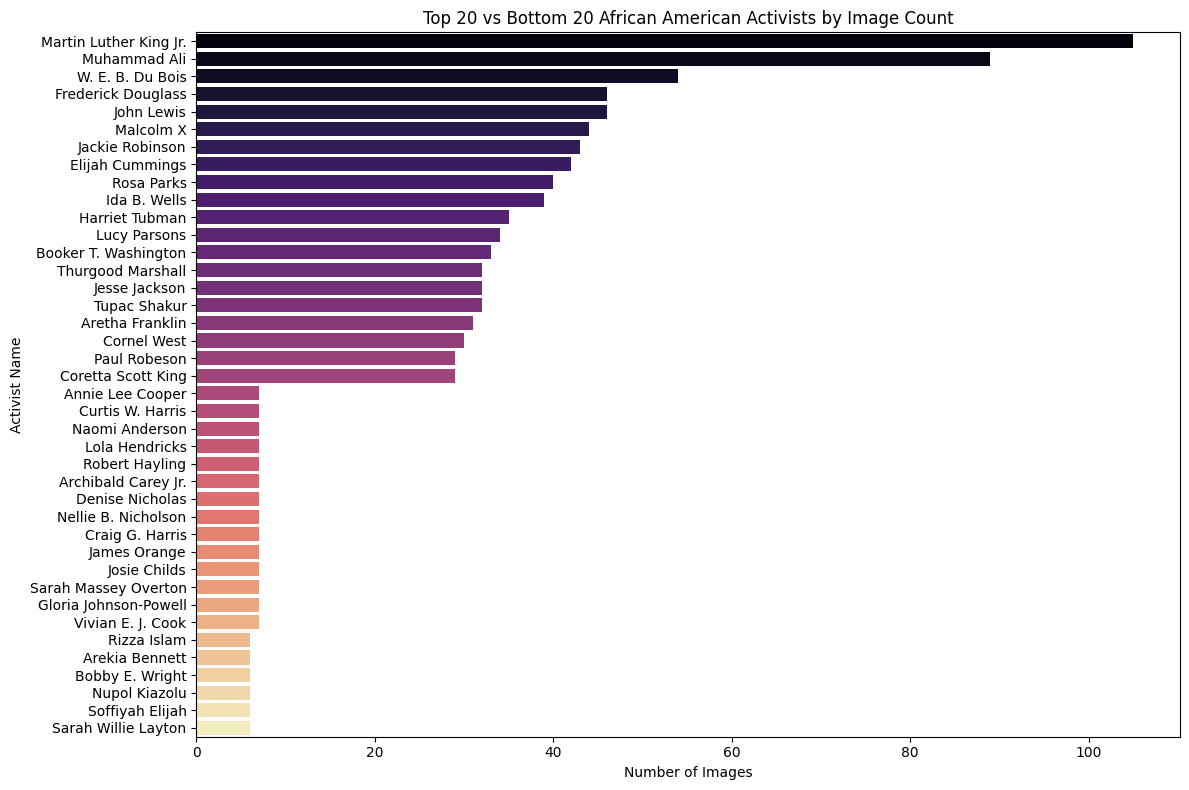

In [56]:
plt.figure(figsize=(12, 8))

#Creating a horizontal bar plot
sns.barplot(x='image_count', y='title', data=df_combined, palette='magma')

#Add labels for readability
plt.xlabel('Number of Images')
plt.ylabel('Activist Name')
plt.title('Top 20 vs Bottom 20 African American Activists by Image Count')

#Rotating x-axis labels for readability
plt.tight_layout()
plt.show()

### The College Educated versus other Activists

In [57]:
 #Creating a function to check if an activist is college educated
def is_college_educated(page_content):
    #Keywords related to education
    education_keywords = ['education', 'university', 'studied', 'college', 'degree', 'graduate', 'school', 'alumni']

    #Looping through all entries for education-related keywords
    for entry in page_content:
        if entry.get("tag") == "ul" and entry.get("text"):
            section_text = entry.get("text")
            if any(re.search(r'\b' + keyword + r'\b', section_text, re.IGNORECASE) for keyword in education_keywords):
                return True

#If not found return
    return False

In [58]:
#Create a dictionary to store the information
activists_education_status = {
    activist_data["title"]: is_college_educated(activist_data["content"])
    for activist_data in AllDetailsAAA
}

In [59]:
#Divide into activists that are college educated and non college educated based on the status
college_educated_activists = [name for name, educated in activists_education_status.items() if educated]
non_college_educated_activists = [name for name, educated in activists_education_status.items() if not educated]


In [60]:
#Print the output to verify
print(f"College Educated: {len(college_educated_activists)}")
print(f"Non-College Educated: {len(non_college_educated_activists)}")

College Educated: 189
Non-College Educated: 22


In [61]:
#Print those with no college education
for name, educated in activists_education_status.items():
    if not educated:
        print(name)

Naomi Anderson
Carl Bean
Lillie Mae Bradford
Beatrice Morrow Cannady
Christine Michel Carter
Fannie Lee Chaney
Ruth Ellis (activist)
Elizabeth Freeman
Bobby Hutton
Nipsey Hussle
Rizza Islam
George Jackson (activist)
Marsha P. Johnson
Sarah Louise Keys
Dangerfield Newby
Sarah Massey Overton
Lucy Parsons
William Pleasant Jr.
Emma J. Ray
Josephine St. Pierre Ruffin
Marion Stamps
Bobby E. Wright


In [62]:
#College vs non college educated activists count for viz
college_educated_count = len(college_educated_activists)
non_college_educated_count = len(non_college_educated_activists)

In [63]:
#Create labels and sizes for the viz
labels = ['College Educated', 'Not College Educated']
sizes = [college_educated_count, non_college_educated_count]
colors = ['#C8B28E', '#70C1B3']

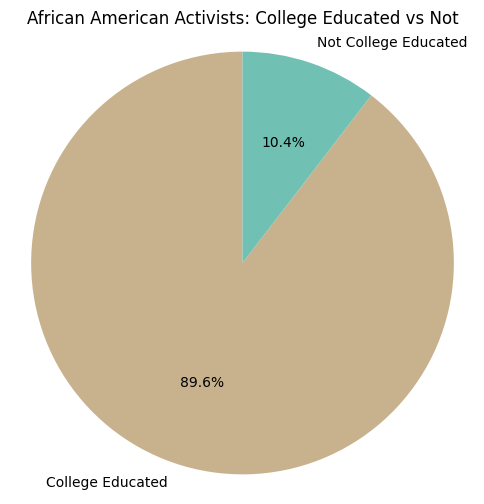

In [64]:
#Plotting the pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
plt.title('African American Activists: College Educated vs Not')
plt.axis('equal')
plt.show()

### Page Section and subsections

In [65]:
#Function to count sections under the Contents tab/section
def count_subsections(content_data):
    subsections_count = 0
    in_contents_section = False

    #Looping through content_data looking for the Contents section
    for entry in content_data:
        if entry.get("tag") == "h2" and entry.get("text") == "Contents":
            in_contents_section = True

        #In the Contents section, find the "ul" tags with section/subsection text
        if in_contents_section and entry.get("tag") == "ul" and entry.get("text"):
            sections_and_subsections = entry.get("text")

            #Ignore any irrelevant entries
            if "Toggle" in sections_and_subsections:
                continue

            #Using the regex to find subsections
            subsections = re.findall(r'(\d+\.\d+)', sections_and_subsections)

            #Counting
            subsections_count += len(subsections)

    return subsections_count

In [66]:
#Start with an empty dictionary to store the results
subsections_info = {}

In [67]:
#Looping through each activist's page in AllDetailsAAA
for page_data in AllDetailsAAA:
    page_title = page_data["title"]
    content_data = page_data["content"]

    #Counting only subsections/sections in the Contents section
    subsections = count_subsections(content_data)

    #Storing the count in subsections_info
    subsections_info[page_title] = subsections

In [68]:
#Print the results for each activist to verify
for page_title, subsections_count in subsections_info.items():
    print(f"{page_title}")
    print(f"Sections/subsections numbers: {subsections_count}\n")

Ralph Abernathy
Sections/subsections numbers: 8

Muhammad Ali
Sections/subsections numbers: 59

Naomi Anderson
Sections/subsections numbers: 1

Maya Angelou
Sections/subsections numbers: 12

Ella Baker
Sections/subsections numbers: 9

James Baldwin
Sections/subsections numbers: 32

Marion Barry
Sections/subsections numbers: 21

Daisy Bates (activist)
Sections/subsections numbers: 4

Carl Bean
Sections/subsections numbers: 1

Arekia Bennett
Sections/subsections numbers: 1

Mary McLeod Bethune
Sections/subsections numbers: 12

James Bevel
Sections/subsections numbers: 8

Sojourner Truth
Sections/subsections numbers: 26

Gloria Blackwell
Sections/subsections numbers: 1

Unita Blackwell
Sections/subsections numbers: 7

Julian Bond
Sections/subsections numbers: 1

Lillie Mae Bradford
Sections/subsections numbers: 1

Ruby Bridges
Sections/subsections numbers: 1

Aurelia Browder
Sections/subsections numbers: 7

Ralph Bunche
Sections/subsections numbers: 7

Nannie Helen Burroughs
Sections/subs

In [69]:
#Organize the data to verify the view
sorted_subsections_info = dict(sorted(subsections_info.items(), key=lambda item: item[1], reverse=True))

In [70]:
#Print the newly organized list
for page_title, subsections_count in sorted_subsections_info.items():
    print(f"{page_title}")
    print(f"Sections/subsections numbers: {subsections_count}\n")

Muhammad Ali
Sections/subsections numbers: 59

Martin Luther King Jr.
Sections/subsections numbers: 53

Frederick Douglass
Sections/subsections numbers: 52

Keith Ellison
Sections/subsections numbers: 51

W. E. B. Du Bois
Sections/subsections numbers: 49

Paul Robeson
Sections/subsections numbers: 42

Al Sharpton
Sections/subsections numbers: 39

Tupac Shakur
Sections/subsections numbers: 39

Anna J. Cooper
Sections/subsections numbers: 36

Ida B. Wells
Sections/subsections numbers: 34

James Baldwin
Sections/subsections numbers: 32

John Lewis
Sections/subsections numbers: 32

Malcolm X
Sections/subsections numbers: 30

Booker T. Washington
Sections/subsections numbers: 29

Sojourner Truth
Sections/subsections numbers: 26

Pauli Murray
Sections/subsections numbers: 26

John Conyers
Sections/subsections numbers: 23

Audre Lorde
Sections/subsections numbers: 22

Jackie Robinson
Sections/subsections numbers: 22

Marion Barry
Sections/subsections numbers: 21

Fred Hampton
Sections/subsect

In [71]:
#Put it in a new dataframe for visualization
dfSections = pd.DataFrame(list(sorted_subsections_info.items()), columns=['Page Title', 'Number of Subsections'])

In [72]:
#View df to verify format
#dfSections

In [73]:
#Sorting the DataFrame by descending order
dfSections_sorted = dfSections.sort_values(by='Number of Subsections', ascending=False)

In [74]:
#Select the top activists for easier display
dfTop40 = dfSections_sorted.head(40)

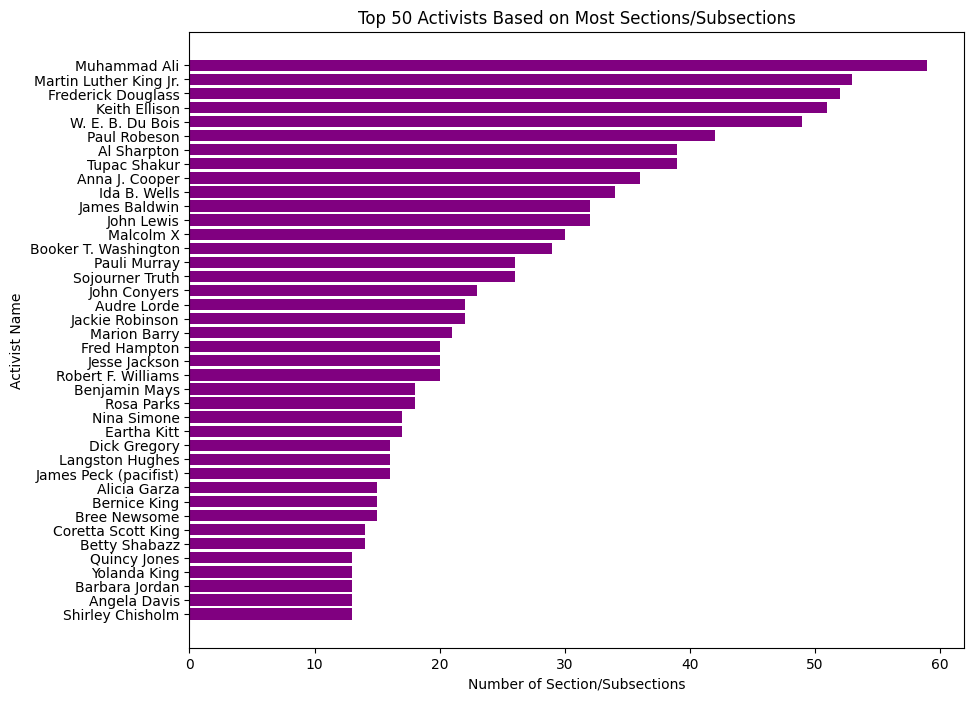

In [75]:
#Creating a horizontal bar chart
plt.figure(figsize=(10, 8))
plt.barh(dfTop40['Page Title'], dfTop40['Number of Subsections'], color='purple')

#Adding titles and labels
plt.xlabel('Number of Section/Subsections')
plt.ylabel('Activist Name')
plt.title('Top 50 Activists Based on Most Sections/Subsections')

#Organizing the order of the bars
plt.gca().invert_yaxis()

### Summary and Additional  Analysis

In [76]:
#Gender pronouns to look for
male_gender = ['he', 'him', 'his', 'himself']
female_gender = ['she', 'her', 'hers', 'herself']


In [77]:

#Educational Keywords to look for
education_keywords = ['university', 'college', 'degree', 'graduated', 'attended', 'education', 'school', 'studied', 'alumni']


In [78]:
#Function to count words on the page
def count_words_in_page(page):
    content = " ".join([item['text'] for item in page.get('content', []) if 'text' in item])
    return len(content.split())

In [79]:
#Function to count gender-specific pronouns
def count_genders(content, gender_pronouns):
    content = content.lower()
    words = re.sub(r'[^\w\s]', '', content).split()
    return sum(word in gender_pronouns for word in words)


In [80]:
#Function to determine if the person has a college education or not
def has_college_education(content):
    #Keywords related to education
    education_keywords = ['university', 'college', 'degree', 'graduated', 'attended', 'alma mater', 'education', 'school', 'studied', 'alumni']
        #Looping through ul sections and check for education-related keywords
    for entry in content:
        if entry.get("tag") == "ul" and entry.get("text"):
            section_text = entry.get("text")
            #Checking for education-related keywords
            if any(re.search(r'\b' + keyword + r'\b', section_text, re.IGNORECASE) for keyword in education_keywords):
                return True

    #Returning if no education-related keywords are found.
    return False

In [81]:
#Function to generate the summary DataFrame
def create_summary_dataframe(AllDetailsAAA):
    combined_data = []

    for page in AllDetailsAAA:
        #Extracting name and ensure proper content extraction
        name = page.get('title', '').split(',')[0]

        #Counting words
        word_count = count_words_in_page(page)

        #Combining content for gender and education determination
        content = page.get('content', [])

        #Counting male and female pronouns
        male_count = count_genders(" ".join([item['text'] for item in content if 'text' in item]), male_gender)
        female_count = count_genders(" ".join([item['text'] for item in content if 'text' in item]), female_gender)

        #Assigning gender based on pronoun counts; # Male = 1, Female = 2, Unknown = 0
        gender = 1 if male_count > female_count else 2
        #Checking for college education
        has_education = 1 if has_college_education(content) else 0

        #Storing the name, word count, gender, and education status
        combined_data.append([name, word_count, gender, has_education])

    #Creating and return DataFrame
    return pd.DataFrame(combined_data, columns=['Name', 'Word Count', 'Gender', 'Has College Education'])

In [82]:
#The summary dataframe and printing to view format
df2 = create_summary_dataframe(AllDetailsAAA)
print(df2)

                 Name  Word Count  Gender  Has College Education
0     Ralph Abernathy        6731       1                      1
1        Muhammad Ali       23893       1                      1
2      Naomi Anderson        1128       2                      0
3        Maya Angelou       11490       2                      1
4          Ella Baker        6356       2                      1
..                ...         ...     ...                    ...
208   Bobby E. Wright        1111       1                      0
209         Malcolm X       18673       1                      1
210      Andrew Young        5840       1                      1
211     Whitney Young        4884       1                      1
212  Sammy Younge Jr.        2558       1                      1

[213 rows x 4 columns]


In [83]:
#Find maya angelou in the df to verify
maya = df2[df2['Name'] == 'Maya Angelou']
print(maya)

           Name  Word Count  Gender  Has College Education
3  Maya Angelou       11490       2                      1


In [84]:
#Find ida b wells in the df to verify
ida = df2[df2['Name'] == 'Ida B. Wells']
print(ida)

             Name  Word Count  Gender  Has College Education
203  Ida B. Wells       16460       2                      1


In [85]:
#Find MLK in the df to verify
mlk = df2[df2['Name'] == 'Martin Luther King Jr.']
print(mlk)

                       Name  Word Count  Gender  Has College Education
120  Martin Luther King Jr.       28903       1                      1


***Linear Regression Model***

In [86]:
#Defining the variables
X = df2[['Has College Education', 'Gender']]
y = df2['Word Count']

In [87]:
#Dividing the variables into 20% test and train 80% sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [88]:
#double check the sets
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(170, 2) (43, 2) (170,) (43,)


In [89]:
#Building the model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [90]:
#Predicting the model
y_pred = model.predict(X_test)

In [91]:
#Evaluating the efficiency of the model
mse_test = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [92]:
#Printing the findings
print("The mean squared error is:", mse_test)
print("The R-squared is:", r2)

The mean squared error is: 17034240.86833224
The R-squared is: 0.07722212027673503


In [93]:
#Get the intercept and coeff
intercept = model.intercept_
coefficients = model.coef_

In [94]:
#print the intercept and coeff
print("Intercept:", intercept)
print("Coefficients:", coefficients)

Intercept: 4514.555422318063
Coefficients: [ 2768.66238739 -1318.55136137]


The above model has a very large mean squared error, indicating that this may not fit the data best. However, during the exploratory phase of the analysis, the decision tree and random forest regression models were built, too, but the linear regression performed best out of the three options. Next, create a stats model for additional insight.

***Stats Model***

In [95]:
#Building a stat model
Smodel = sm.OLS(y, X).fit()

In [96]:
#Printing the output
print(Smodel.summary())

                                 OLS Regression Results                                
Dep. Variable:             Word Count   R-squared (uncentered):                   0.546
Model:                            OLS   Adj. R-squared (uncentered):              0.542
Method:                 Least Squares   F-statistic:                              127.1
Date:                Tue, 28 Jan 2025   Prob (F-statistic):                    5.96e-37
Time:                        20:18:24   Log-Likelihood:                         -2105.0
No. Observations:                 213   AIC:                                      4214.
Df Residuals:                     211   BIC:                                      4221.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

As shown above, the stats model shows statistical significance between word count and whether the person went to college. Moreover, the coefficient displays that those with a college degree have an average of 5200 words on their Wikipedia page. In fact, the p value displayed is 0.000, meaning it's lower than the threshold of 0.05, which is considered at the top range for statistical significance. However, there is no statistical significance between word count and gender, as the p-value is 0.653, well over the 0.05 threshold. Additionally, there seems to be only around a 203 word count difference based on the activist's gender.

# Findings


In [97]:
#Separate data into men and women for viz
men = df2[df2['Gender'] == 1]
women = df2[df2['Gender'] == 2]

In [98]:
#Top 10 men by word count
top_10_men = men.sort_values(by='Word Count', ascending=False).head(10)
print(top_10_men[['Name', 'Word Count']])

                       Name  Word Count
120  Martin Luther King Jr.       28903
1              Muhammad Ali       23893
53       Frederick Douglass       21925
54         W. E. B. Du Bois       21326
99            Jesse Jackson       20691
209               Malcolm X       18673
5             James Baldwin       17514
174            Paul Robeson       16420
128              John Lewis       16143
195            Tupac Shakur       15698


In [99]:
#Top 10 women by word count
top_10_women = women.sort_values(by='Word Count', ascending=False).head(10)

In [100]:
#Print the output for the top 10 women
print(top_10_women[['Name', 'Word Count']])


                   Name  Word Count
203        Ida B. Wells       16460
117  Coretta Scott King       16283
158          Rosa Parks       15758
68      Aretha Franklin       12931
101     Mahalia Jackson       12495
197      Harriet Tubman       12222
129         Audre Lorde       12106
3          Maya Angelou       11490
47         Angela Davis       10880
196     Sojourner Truth       10244


In [101]:
#Top 10 college educated men by word count
educated_men = men[men['Has College Education'] == 1]
top_10_educated_men = educated_men.sort_values(by='Word Count', ascending=False).head(10)

In [102]:
#Print the top 10 college educated men Activists
print(top_10_educated_men[['Name', 'Word Count']])


                       Name  Word Count
120  Martin Luther King Jr.       28903
1              Muhammad Ali       23893
53       Frederick Douglass       21925
54         W. E. B. Du Bois       21326
99            Jesse Jackson       20691
209               Malcolm X       18673
5             James Baldwin       17514
174            Paul Robeson       16420
128              John Lewis       16143
195            Tupac Shakur       15698


In [103]:
#Top 10 college educated women by word count
educated_women = women[women['Has College Education'] == 1]
top_10_educated_women = educated_women.sort_values(by='Word Count', ascending=False).head(10)

In [104]:
#Print top 10 college educated women Activists
print(top_10_educated_women[['Name', 'Word Count']])

                   Name  Word Count
203        Ida B. Wells       16460
117  Coretta Scott King       16283
158          Rosa Parks       15758
68      Aretha Franklin       12931
101     Mahalia Jackson       12495
197      Harriet Tubman       12222
129         Audre Lorde       12106
3          Maya Angelou       11490
47         Angela Davis       10880
196     Sojourner Truth       10244


Now for a final visualization for all the analysis to best answer the original research question.

In [105]:
#Data for Top 10 Men by Word Count
top_10_men = pd.DataFrame({
    'Name': ['Martin Luther King Jr.', 'Muhammad Ali', 'Frederick Douglass', 'W. E. B. Du Bois',
             'Jesse Jackson', 'Malcolm X', 'James Baldwin', 'Paul Robeson', 'John Lewis', 'Tupac Shakur'],
    'Word Count': [28903, 23893, 21925, 21326, 20691, 18675, 17514, 16420, 16143, 15695],
    'Category': ['Men'] * 10
})

In [106]:
#Data for Top 10 Women by Word Count for viz
top_10_women = pd.DataFrame({
    'Name': ['Ida B. Wells', 'Coretta Scott King', 'Rosa Parks', 'Aretha Franklin', 'Mahalia Jackson',
             'Harriet Tubman', 'Audre Lorde', 'Maya Angelou', 'Angela Davis', 'Sojourner Truth'],
    'Word Count': [16457, 16283, 15686, 12931, 12495, 12221, 12106, 11490, 10938, 10244],
    'Category': ['Women'] * 10})

In [107]:
#Data for Top 10 Educated Men by Word Count for viz
top_10_educated_men = pd.DataFrame({
    'Name': ['Martin Luther King Jr.', 'Muhammad Ali', 'Frederick Douglass', 'W. E. B. Du Bois',
             'Jesse Jackson', 'Malcolm X', 'James Baldwin', 'Paul Robeson', 'John Lewis', 'Tupac Shakur'],
    'Word Count': [28903, 23893, 21925, 21326, 20691, 18675, 17514, 16420, 16143, 15695],
    'Category': ['Educated Men'] * 10
})

In [108]:
#Data for Top 10 Educated Women by Word Count
top_10_educated_women = pd.DataFrame({
    'Name': ['Ida B. Wells', 'Coretta Scott King', 'Rosa Parks', 'Aretha Franklin', 'Mahalia Jackson',
             'Harriet Tubman', 'Audre Lorde', 'Maya Angelou', 'Angela Davis', 'Sojourner Truth'],
    'Word Count': [16457, 16283, 15686, 12931, 12495, 12221, 12106, 11490, 10938, 10244],
    'Category': ['Educated Women'] * 10
})

In [109]:
#Combining the dataframes for easy visualization
combined_data = pd.concat([top_10_men, top_10_women, top_10_educated_men, top_10_educated_women])

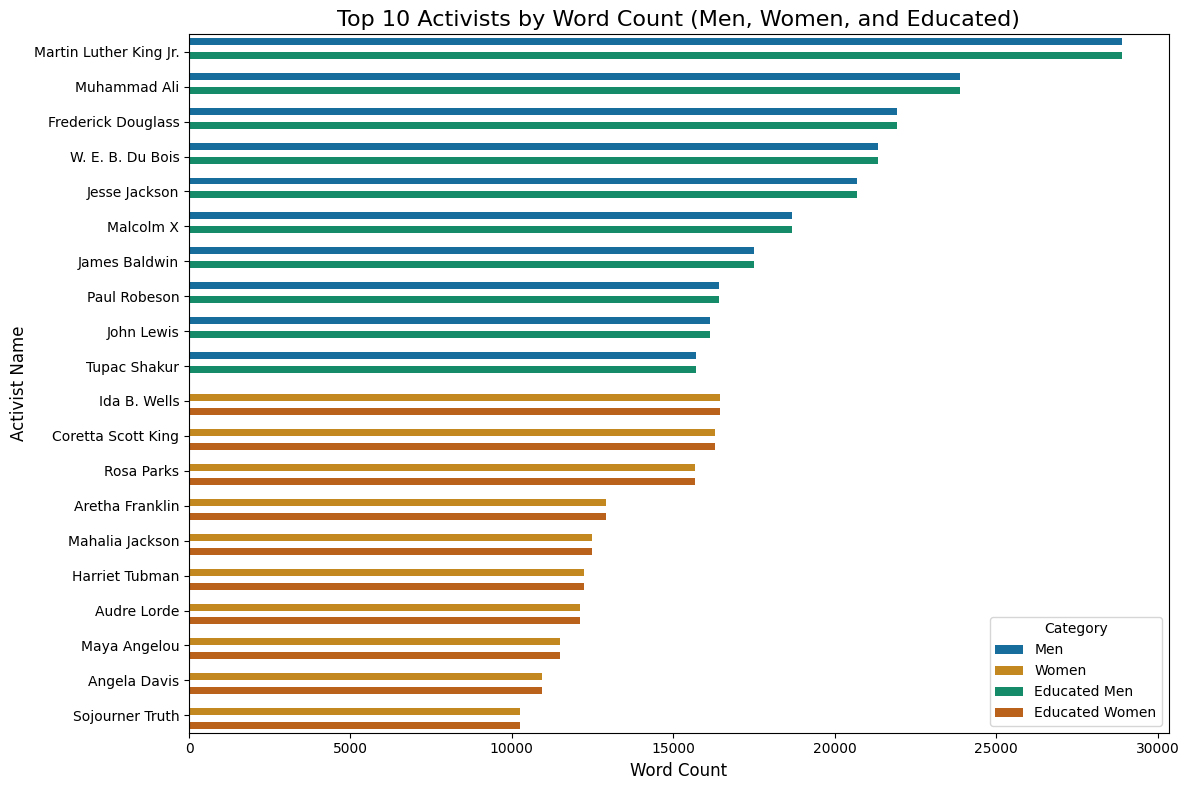

In [110]:
#Creating the combined plot
plt.figure(figsize=(12, 8))

#Use seaborn barplot for better aesthetics
sns.barplot(x='Word Count', y='Name', hue='Category', data=combined_data, palette='colorblind')

#Adding titles for readability
plt.title('Top 10 Activists by Word Count (Men, Women, and Educated)', fontsize=16)
plt.xlabel('Word Count', fontsize=12)
plt.ylabel('Activist Name', fontsize=12)

#Adjusting the layout for better visibility
plt.tight_layout()

The research questions this project set out to answer were: What differences exist in African American activists' recognition and visibility, and how do formal and informal educations affect their importance and impact in advocacy, especially for women in American history?

The most noticeable difference among African American activists' recognition and visibility and how it relates to their formal or informal education is Martin Luther King Jr.  His page, by far, had the most word count, and with great reason, considering his contribution and sacrifice for the Civil Rights movement. Moreover, having a doctorate may have provided him with speaking and writing opportunities to hone his further. Another notable member of the King family, Coretta Scott King, was the second highest ranking for word counts among educated women. Although she didn’t have a doctorate, she had a bachelor’s degree, which may have provided additional tools for her journey into the spotlight along with her husband.

The woman with the highest word count was Ida B. Wells, who attended university but was kicked out sadly. Once again, this type of information required additional research for insight. Regardless, Ida contributed to multiple fields and personally fed my interest in analytics and sociology. Her work on analyzing lynching data in the South was instrumental in creating awareness of a horrific period in American history.


The research question was answered in a few different ways. As shown in the analysis above, education played a role in the impact and contributions of many African American activists. This was proved by the word count on the activist’s Wikipedia page. However, the activists’ page might have mentioned a college or university where they either spoke, performed, or were a part in some other manner without attending as a student. This presents the limitations of the scrapping tool and the analysis to follow, as it doesn’t always provide the whole picture, and additional analysis with different data points might be needed for more precise insights. However, one can look through these findings and relish the impact of these great activists while noting that their levels of education did not hold them back from making their contribution to Civil Rights and other social justice movements. An example is Sojourner Truth, famously known as an abolitionist, women's rights activist, and a powerful speaker; however, she couldn’t read or write. As expected, many enslaved people were not taught to read or write. Nevertheless, her contribution to social justice remains remarkable.


Whether formal or informal, education does influence African American activists' recognition and visibility and their importance and impact in advocacy. Future activists should consider pursuing higher education as it may provide additional tools and recognition for them to advocate effectively; however, a lack of education or inaccessibility shouldn't deter them.

# Bibilography

Goldin, C., Katz, L. F., & Kuziemko, I. (2006). The Homecoming of American College Women: The Reversal of the College Gender Gap. Journal of Economic Perspectives, 20(4), 133–156. https://doi.org/10.1257/jep.20.4.133

Herndon, M. (2024, June 28). Excluded from National Leadership, Black Women Were the Backbone of the Civil Rights Movement | Smithsonian American Women’s History Museum. Womenshistory.si.edu. https://womenshistory.si.edu/blog/excluded-national-leadership-black-women-were-backbone-civil-rights-movement

List of African-American activists. (2022, January 20). Wikipedia. https://en.wikipedia.org/wiki/List_of_African-American_activists

MediaWiki API help - Wikipedia. (n.d.). En.wikipedia.org. https://en.wikipedia.org/w/api.php

Michals, D. (2015). Sojourner Truth. National Women’s History Museum; National Women’s History Museum. https://www.womenshistory.org/education-resources/biographies/sojourner-truth

NAACP. (2022). Martin Luther King, Jr. NAACP; NAACP. https://naacp.org/find-resources/history-explained/civil-rights-leaders/martin-luther-king-jr

Norwood, A. (2017). Ida B. Wells-Barnett. National Women’s History Museum. https://www.womenshistory.org/education-resources/biographies/ida-b-wells-barnett

Norwood, A. R. (2017). Coretta Scott King. National Women’s History Museum. https://www.womenshistory.org/education-resources/biographies/coretta-scott-king
